In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [3]:

gamma = 0.99
num_episodes = 500
max_time = 10000
device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.output_layer(x)
        action_probs = F.softmax(actions, dim=1)
        return action_probs

In [5]:
class StateValueNetwork(nn.Module):
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        state_value = self.output_layer(x)
        return state_value

In [6]:
def select_action(network, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    action_probs = network(state)
    state = state.detach()
    m = Categorical(action_probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

In [7]:
def process_rewards(rewards):
    Disc_return = []
    total_r = 0
    for r in reversed(rewards):
        total_r = r + total_r * gamma
        Disc_return.insert(0, total_r)
    Disc_return = torch.tensor(Disc_return).to(DEVICE)
    Disc_return = (Disc_return - Disc_return.mean())/Disc_return.std()
    return Disc_return

In [8]:
def train_policy(deltas, log_probs, optimizer):
    policy_loss = []
    for d, lp in zip(deltas, log_probs):
        policy_loss.append(-d * lp)
    optimizer.zero_grad()
    sum(policy_loss).backward()
    optimizer.step()


In [9]:
def train_value(next_state_vals, state_vals,rewards, optimizer):
    rewards=torch.tensor(rewards)
    val_loss = F.mse_loss(state_vals, next_state_vals+rewards)
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()


In [10]:
total_scores_type1 = []
tau = 0.05
recent_scores = deque(maxlen=100)
for expt in range(5):
  env = gym.make('Acrobot-v1')

  policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
  stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(device)
  stateval_network_target = StateValueNetwork(env.observation_space.shape[0]).to(device)

  policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.003)
  stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=0.01)
  scores=[]
  for episode in tqdm_notebook(range(num_episodes)):
      state = env.reset()
      trajectory = []
      score = 0
      discounted_return = 0
      state_vals = []
      next_state_vals =[]
      for step in range(max_time):
          action, lp = select_action(policy_network, state)
          new_state, reward, done, _ = env.step(action)
          score += reward
          discounted_return = reward+0.99*(discounted_return)
          trajectory.append([state,new_state, action, reward, lp])
          if done:
              break
          state = new_state
      scores.append(score)
      recent_scores.append(score)
      states = [step[0] for step in trajectory]
      next_states = [step[1] for step in trajectory]
      actions = [step[2] for step in trajectory]
      rewards = [step[3] for step in trajectory]
      lps = [step[4] for step in trajectory]
      G = process_rewards(rewards)

      for state in states:
          state = torch.from_numpy(state).float().unsqueeze(0).to(device)

          state_vals.append(stateval_network(state))

      state_vals = torch.stack(state_vals).squeeze()

      for next_state in next_states:
          next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)

          next_state_vals.append(stateval_network(next_state))

      next_state_vals = torch.stack(next_state_vals).squeeze()

      train_value(next_state_vals, state_vals,rewards, stateval_optimizer)

      # Defining the delta value without baseline
      deltas = G
      deltas = torch.tensor(deltas).to(device)

      train_policy(deltas, lps, policy_optimizer)
  total_scores_type1.append(scores)
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-10-0c9a3043d1bc>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-10-0c9a3043d1bc>:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deltas = torch.tensor(deltas).to(DEVICE)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `n

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
total_scores_type2 = []
tau = 0.05
recent_scores = deque(maxlen=100)
for expt in range(5):
  env = gym.make('Acrobot-v1')

  policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
  stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(device)
  stateval_network_target = StateValueNetwork(env.observation_space.shape[0]).to(device)

  policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.003)
  stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=0.01)
  scores=[]
  for episode in tqdm_notebook(range(num_episodes)):
      state = env.reset()
      trajectory = []
      score = 0
      discounted_return = 0
      state_vals = []
      next_state_vals =[]
      for step in range(max_time):
          action, lp = select_action(policy_network, state)
          new_state, reward, done, _ = env.step(action)
          score += reward
          discounted_return = reward+0.99*(discounted_return)
          trajectory.append([state,new_state, action, reward, lp])
          if done:
              break
          state = new_state
      scores.append(score)
      recent_scores.append(score)
      states = [step[0] for step in trajectory]
      next_states = [step[1] for step in trajectory]
      actions = [step[2] for step in trajectory]
      rewards = [step[3] for step in trajectory]
      lps = [step[4] for step in trajectory]
      G = process_rewards(rewards)

      for state in states:
          state = torch.from_numpy(state).float().unsqueeze(0).to(device)

          state_vals.append(stateval_network(state))

      state_vals = torch.stack(state_vals).squeeze()

      for next_state in next_states:
          next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)

          next_state_vals.append(stateval_network(next_state))

      next_state_vals = torch.stack(next_state_vals).squeeze()

      train_value(next_state_vals, state_vals,rewards, stateval_optimizer)

      # Defining the delta value with baseline
      deltas = [gt - val for gt, val in zip(G, state_vals)]
      deltas = torch.tensor(deltas).to(device)

      train_policy(deltas, lps, policy_optimizer)
  total_scores_type2.append(scores)
env.close()

<ipython-input-12-a47e805901da>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

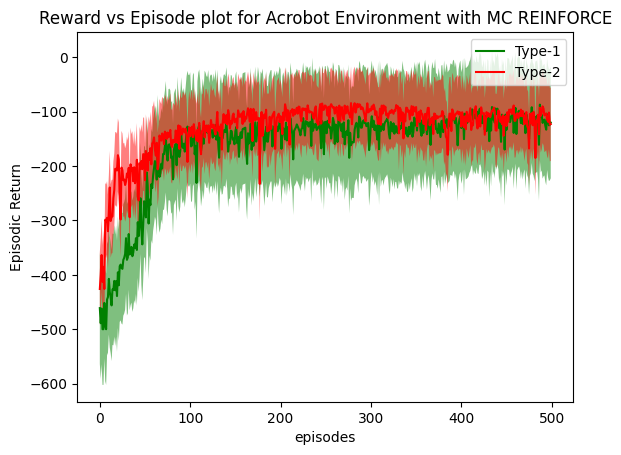

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

#sns.set()

array_rewards_type1 = np.array(total_scores_type1)
transposed_lists_type1 = np.array(total_scores_type1).T
std_deviations_type1 = np.std(transposed_lists_type1, axis=1)
rewards_std_type1 = np.std(transposed_lists_type1)
mean_rewards_type1 = np.mean(array_rewards_type1,axis=0)

array_rewards_type2 = np.array(total_scores_type2)
transposed_lists_type2 = np.array(total_scores_type2).T
std_deviations_type2 = np.std(transposed_lists_type2, axis=1)
rewards_std_type2= np.std(transposed_lists_type2)
mean_rewards_type2 = np.mean(array_rewards_type2,axis=0)

plt.plot(mean_rewards_type1,color='green',label='Type-1')
plt.fill_between(np.arange(0,500),mean_rewards_type1-rewards_std_type1,mean_rewards_type1+rewards_std_type1,alpha=0.5,facecolor='green')
plt.plot(mean_rewards_type2,color='red',label='Type-2')
plt.fill_between(np.arange(0,500),mean_rewards_type2-rewards_std_type2,mean_rewards_type2+rewards_std_type2,alpha=0.5,facecolor='red')
plt.ylabel('Episodic Return')
plt.xlabel('episodes')
plt.legend()
plt.title('Reward vs Episode plot for Acrobot Environment with MC REINFORCE')

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
